# Глубокая Q-сеть, вариант многослойного перцептрона 5 баллов

#### дедлайн задания: 24 ноября 23:59

В данной домашней работе требуется реализовать DQN &mdash; приближённый алгоритм Q-обучения c механизмом _experience_ _replay_ и целевой сетью (_target network_) &mdash; и пронаблюдать, лучше ли подход DQN работает по сравнению с рассмотренными ранее в каком-либо аспекте.

Исходная статья:
https://arxiv.org/pdf/1312.5602.pdf

Конспект теории по глубокому Q-обучению:
https://arxiv.org/pdf/2201.09746.pdf (главы 4.1 и 4.2)

# Работа выполнена: Терентьев Александр Андрееевич, Б05-003.

В данном задании требуется обучить агента в среде CartPole. По идее, процесс обучения должен занять несколько десятков минут.

In [136]:
%pip install gym

Note: you may need to restart the kernel to use updated packages.


In [137]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import utils
from IPython.display import HTML
import os

### CartPole, снова

In [138]:
ENV_NAME = "CartPole-v1"


# нужно потому что в новой версии нельзя просто так передать seed
class reset_seed_wrapper(gym.Wrapper):
    def __init__(self, env, seed):
        super().__init__(env)
        self.seed = seed
    def reset(self):
        return self.env.reset(seed= self.seed)[0] # откидываем ненужное
    def step(self, action):
        s, r, done, info, _ = self.env.step(action, )
        return s, r, done, info
def make_env(seed=None):
    # CartPole обёрнут в time limit wrapper по умолчанию
    env = gym.make(ENV_NAME).unwrapped
    env = reset_seed_wrapper(env, seed)
    return env


In [139]:
env = make_env()
state = env.reset()
state

array([ 0.04135224, -0.04618777, -0.0385196 ,  0.01354661], dtype=float32)

In [140]:
state_shape = env.observation_space.shape
state_shape

(4,)

In [141]:
n_actions = env.action_space.n
n_actions

2

# Приближённое Q-обучение: построение сети

Теперь требуется построить нейронную сеть, способную отображать наблюдения в Q-ценности состояния. Так как происходит работа с предобработанными признаками (положения тележки, углы и скорости), то не требуется сложная нейронная сеть пока. Фактически, нужно построить нейронную сеть с архитектурой, обозначенной снизу:

<img src=https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png width=640>

В идеале рекомендуется начать с небольших 1-2 скрытых слоёв с < 200 нейронов и затем увеличить размер сети, если агент не может получить целевую награду. Батч-нормализация и дропаут здесь могут всё испортить. Также рекомендуется избегать использование таких нелинейностей, как функция сигмоиды и гиперболического тангенса: наблюдения агента не нормализованы, так что сигмоиды могут концентрироваться у нуля.

In [142]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# те, кто имеют GPU, но не хотят использовать графический вычислитель, могут раскомментировать:
device = torch.device('cpu')
device

device(type='cpu')

In [143]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        # Задайте структуру нейронной сети здесь. 
        # Убедитесь в том, что здесь определёны все параметры агента.
        assert len(state_shape) == 1
        state_dim = state_shape[0]
        self.net = nn.Sequential(
            nn.Linear(self.state_shape[0], 100),
            nn.Softplus(),
            nn.Linear(100, 100),
            nn.Softplus(),
            nn.Linear(100, 100),
            nn.Softplus(),
            nn.Linear(100, self.n_actions)
        )

        
    def forward(self, state_t):
        """
        принимает наблюдение агента (тензор), возвращает qvalues (тензор)
        :параметр state_t: батч состояний, размерность = [batch_size, *state_dim=4]
        """
        # Используйте Вашу нейросеть для вычисления qvalues данного состояния state_t
        qvalues = self.net(state_t)

        assert qvalues.requires_grad, "qvalues должны быть torch tensor с возможностью дифференцирования"
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        Как forward, только работает на numpy arrays, не на тензорах
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """Выбрать действия для данных qvalues. Использует эпсилон-жадную стратегию исследования среды."""
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [144]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Теперь давайте проверим нашего агента на предмет наличия ошибок.

In [145]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """Играет qvalues полных эпизодов. Если greedy=True, то действия берутся из детерминированной
    стратегии как argmax(qvalues). Возвращает среднюю награду."""
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        print(s)
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = (
                qvalues.argmax(axis=-1)[0]
                if greedy
                else agent.sample_actions(qvalues)[0]
            )
            s, r, done, info = env.step(action, )
            reward += r
            if done:
                break

        rewards.append(reward)
    env.close()
    return np.mean(rewards)

In [146]:
evaluate(env, agent, n_games=1)

9.0

# Experience Replay
Сущетвует мощный метод, который можно использовать для улучшения сходимости _off-policy_ алгоритмов относительно общего количества используемых сэмплов: _Experience_ _Replay_. Смысл состоит в том, что появляется возможность настроить агента с помощью Q-обучения и EV-SARSA на кортежах `<s,a,r,s'>`, даже если они не сэмплированы из текущей политики агента. Итак, здесь требуется реализовать следующее:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=640>

#### Обучение с experience replay
1. Сыграть шаг игры, отсэмплировать `<s,a,r,s'>`.
2. Обновить q-values на основе `<s,a,r,s'>`.
3. Записать `<s,a,r,s'>` в буфер. 
 3. Если буфер полный, то удалить ранние данные.
4. Сэмплировать K таких переходов из данного буфера и обновить q-values на их основе.

#### Интерфейс довольно простой:
* `exp_replay.add(obs, act, rw, next_obs, done)`  &mdash; сохраняет кортеж (s,a,r,s',done) в буфер
* `exp_replay.sample(batch_size)` &mdash; возвращает наблюдения, действия, награды, следующие наблюдения и is_done для `batch_size` случайных сэмплов.
* `len(exp_replay)` &mdash; возвращает количество элиментов, хранящихся в буфере на данный момент.


Для применения такого обучения требуется, во-первых, реализация структуры памяти, которая будет работать как буфер.

In [147]:
class ReplayBuffer(object):
    def __init__(self, size):
        """
        Создаёт буфер реплеев.
        Параметры
        ----------
        size: int
            Максимальное количество хранящихся единовременно переходов. При переполнении буфера старые
            записи удаляются.

        Замечание: для данного задания можно выбрать любую структуру данных.
              Если Вам достаточно простого решения, то можно просто хранить список кортежей (s, a, r, s')
              в self._storage. Однако, можно найти более быстрые и/или эффективные по памяти способы
              реализации самого хранения переходов.
        """
        self._storage = []
        self._maxsize = size

        # Дополнительно: Ваш код

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Убедитесь, что _storage не превзойдёт по размерам _maxsize. 
        Убедитесь, что FIFO правило выполняется: старейшие прецеденты должны удаляться раньше всех.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        storage = self._storage
        maxsize = self._maxsize
        if len(storage) >= maxsize:
            del storage[0]
        storage.append(data)
            # добавить данные в storage

    def sample(self, batch_size):
        """Сэмплирование батча переходов.
        Параметры
        ----------
        batch_size: int
            Сколько переходов сэмплировать.
        Возвращает
        -------
        obs_batch: np.array
            батч наблюдений (состояний)
        act_batch: np.array
            батч действий, выполненных на основе obs_batch
        rew_batch: np.array
            награды, полученные в качестве результата выполнения act_batch
        next_obs_batch: np.array
            следующие наблюдения (состояния), полученные после выполнения act_batch
        done_mask: np.array
            done_mask[i] = 1, если выполнение act_batch[i] повлекло
            окончание эпизода и 0 иначе.
        """
        storage = self._storage

        indices = np.random.choice(len(storage), batch_size)
            # < случайно сгенерировать batch_size индексов сэмплов в буфере >
            
        tmp = [[storage[ind][el] for ind in indices] for el in range(5)]
        s, a, r, s_, done = (np.stack(tmp[i], axis = 0) for i in range(5))
            # собрать <s,a,r,s',done> для каждого индекса
        
        return s, a, r, s_, done
            # < states > , < actions >, < rewards >,  < next_states >, < is_done >

In [148]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(), 1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert (
    len(exp_replay) == 10
), "размер буфера должен быть равен 10, потому что это максимальная вместимость"

In [149]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Сыграть в игру n_steps шагов, записать каждый (s,a,r,s', done) в exp_replay буфер.
    Как только игра заканчивается, добавляется запись с done=True и среда env перезапускается.
    Гарантируетcя, что env находится в состоянии done=False после работы функции.

    ПРОСЬБА НЕ ПЕРЕЗАПУСКАТЬ ENV, ПОКА ОНА НЕ В СОСТОЯНИИ "DONE"

    :возвращает: сумму наград по времени и состояние, в котором среда оказалась
    """
    s = initial_state
    cum_r = 0

    # Сыграть в игру n_steps шагов согласно инструкциям выше
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        new_s, r, done, info = env.step(action)
        cum_r += r
        exp_replay.add(s, action, r, new_s, done )
        s = new_s
        if done:
            s = env.reset()

    return cum_r, s

In [150]:
# Протестируйте Ваш код.
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# если вы используете собственный experience replay буфер, то некоторые из тестов, возможно, потребуется
# скорректировать.
# Убедитесь в том, что Вы знаете, что Ваш код делает
assert len(exp_replay) == 1000, (
    "play_and_record должна добавить ровно 1000 шагов, "
    "но вместо этого добавила %i" % len(exp_replay)
)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, (
    "Убедитесь, что Вы перезапускаете игру, как только она 'done', и корректно записываете is_done в буфер."
    "Получена %f доля is_done за %i шагов. [Если думаете, что Вам не повезло, то просто перезапустите тест.]"
    % (np.mean(is_dones), len(exp_replay))
)

for _ in range(100):
    (
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
    ) = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (
        10,
    ), "батч действий должен иметь размер (10,), но имееет %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,
    ), "батч наград должен иметь размер (10,), но имееет %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,
    ), "батч is_done должен иметь размер (10,), но имееет %s" % str(is_done_batch.shape)
    assert [
        int(i) in (0, 1) for i in is_dones
    ], "is_done должен быть строго True или False"
    assert [
        0 <= a < n_actions for a in act_batch
    ], "действия должны быть в промежутке [0, n_actions]"

print("Отлично справились!")

Отлично справились!


# Целевые сети

Также будет реализована так называемая "целевая сеть" &mdash; копия весов нейронной сети агента, используемая для оценки целевого значения Q-функции:

Сама по себе сеть представляет собой точную копию сети агента, но её параметры не обучаются. Наоборот, они берутся из обучаемой сети агента раз в несколько итераций цикла обучения.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png width=480>

In [151]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# Так можно загружать веса из агента в целевую сеть
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Обучение с помощью... Q-обучения
Тут будет реализована функция, похожая на `agent.update` из табличного Q-обучения.

Вычислить TD ошибку Q-обучения:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

С $Q_{reference}$, определённой как:

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Где
* $Q_{target}(s',a')$ обозначает Q-ценность следующего состояния и следующего действия, предсказанного с помощью __target_network__
* $s, a, r, s'$ суть текущие состояние, действие, награда и следующее состояние соответственно
* $\gamma$ фактор дисконта, определённый двумя блоками выше.


__Замечание 1:__ ниже представлен пример входных данных. Не бойтесь с ним экспериментировать, прежде чем написать непосредственно функцию.

__Замечание 2:__ compute_td_loss есть источник приблизительно 99% ошибок в данной домашней работе. Если награда не увеличивается, то часто в подобных случаях помогает построчная отладка с помощью [резиновой утки](https://rubberduckdebugging.com/).

In [152]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Вычислите td функцию потерь, используя только операции PyTorch. Используйте формулы выше. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # размер: [batch_size, *state_shape]
    # print('S', states)

    actions = torch.tensor(actions, device=device, dtype=torch.long)    # размер: [batch_size]
    # print('A', actions)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # размер: [batch_size]
    # print('R', rewards)
    # размер: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    # print("S'", next_states)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # размер: [batch_size]
    is_not_done = 1 - is_done
    # print('done', is_not_done)

    # получить q-values для всех действий в текущих состояниях
    predicted_qvalues = agent(states)
    # print('Q(s,a)', predicted_qvalues)

    # вычислить q-values для всех действий в следующих состояниях
    predicted_next_qvalues = target_network(next_states)
    # print("Q(s',a')", predicted_next_qvalues)
    
    # выбрать q-values для соотоветствующих выбранных действий
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]
    # print('selected Q(s, a)', predicted_qvalues_for_actions)

    # вычислить V*(next_states), используя предсказанные следующие q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]

    assert next_state_values.dim(
    ) == 1 and next_state_values.shape[0] == states.shape[0], "нужно предсказывать одно действие для состояния"

    # вычислить "target q-values" для функции потерь - то, что внутри квадратных скобок в формуле выше.
    # в последнем состоянии использовать упрощённую формулу: Q(s,a) = r(s,a) так как s' не существует
    # Вы можете умножить следующие состояния на is_not_done для достижения этого.
    target_qvalues_for_actions = rewards + gamma *  next_state_values * is_not_done

    # среднеквадратическая функция потерь для минимизации
    
    assert predicted_qvalues_for_actions.shape == target_qvalues_for_actions.shape
    
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)
    # print('loss vector', (predicted_qvalues_for_actions -
    #                   target_qvalues_for_actions.detach()) ** 2)
    # print('loss', loss)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "убедитесь, что Вы предсказали все q-values для всех действий в следующих состояниях"
        assert next_state_values.data.dim(
        ) == 1, "убедитесь, что Вы вычислили V(s') как максимум по оси действий в тензоре, а не по всем осям"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "что-то не то с целевыми q-values, они должны быть вектором"

    return loss

Проверка корректности реализации

In [153]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10
)

loss = compute_td_loss(
    obs_batch,
    act_batch,
    reward_batch,
    next_obs_batch,
    is_done_batch,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=True,
)
loss.backward()

assert (
    loss.requires_grad and tuple(loss.data.size()) == ()
), "Вы должны вернуть скаляр значения функции потерь - среднее по батчу."
assert np.any(
    next(agent.parameters()).grad.data.cpu().numpy() != 0
), "Функция потерь должна быть дифференцируема относительно весов сети."
assert np.all(
    next(target_network.parameters()).grad is None
), "Целевая сеть не должна быть дифференцируемой."

# Основной цикл

Время собрать всё вместе и посмотреть, обучается ли что-нибудь.

In [154]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [155]:
seed = int(5)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [156]:
env = make_env(seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [157]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print(
            """
            Меньше, чем 100 Mb RAM, доступно. 
            Убедитесь, что размер буфера не слишком большой.
            Также проверьте, может, другие процессы потребляют сильно много RAM.
            """
        )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [158]:
timesteps_per_epoch = 100
batch_size = 42
total_steps = 3 * 10**4
decay_steps = 1 * 10**4

opt = torch.optim.RMSprop(agent.parameters(), lr=1e-3)
opt.zero_grad()

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 10
gamma = 0.99

In [159]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

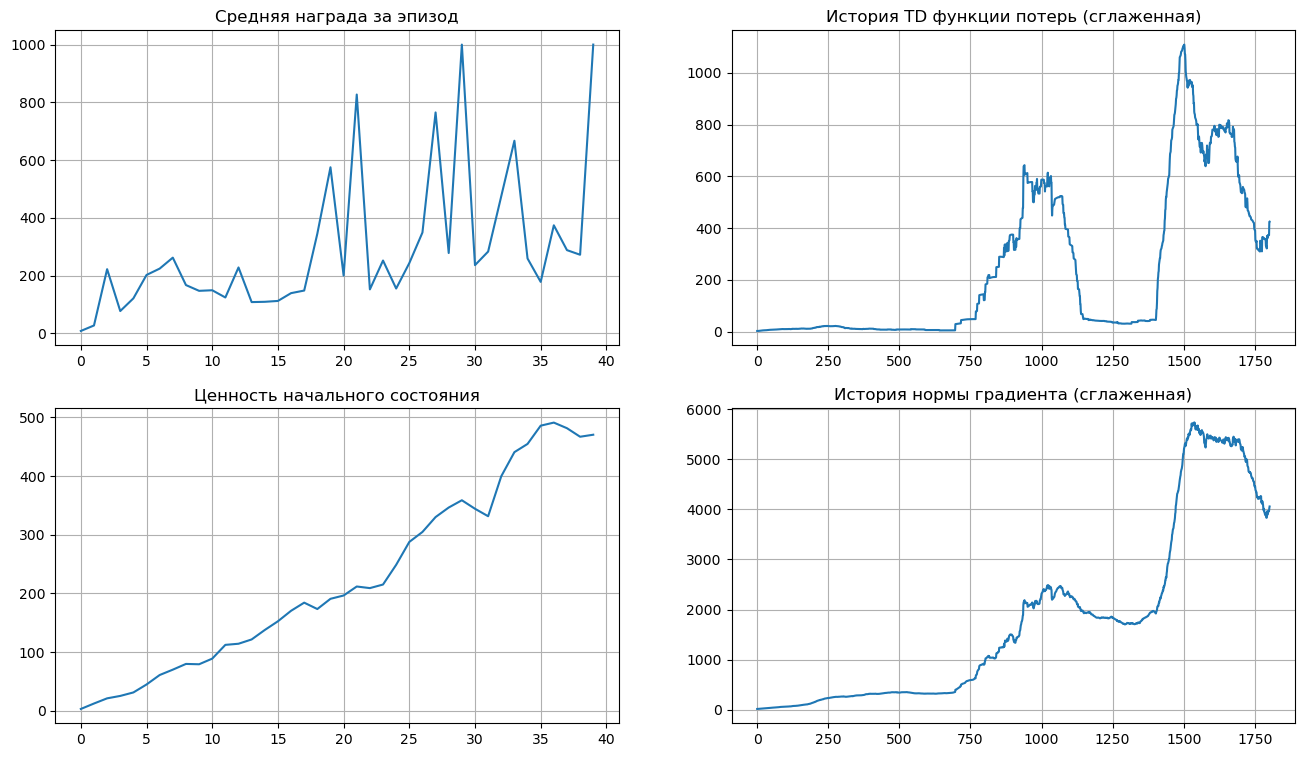

 27%|██▋       | 8029/30001 [03:53<10:39, 34.33it/s]


KeyboardInterrupt: 

In [162]:
state = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('Меньше, чем 100 Mb RAM, доступно, заморозка процедуры обучения')
        print('убедитесь, что всё в порядке и пошлите сигнал KeyboardInterrupt для продолжения')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # игра
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # обучение
    s, a, r, s_, done = exp_replay.sample(batch_size)

    loss = compute_td_loss(s, a, r, s_, done, agent, target_network, gamma)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm).item()
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Загрузка весов агента в target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # Оценка агента
        mean_rw_history.append(evaluate(
            make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        print("размер буфера = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Средняя награда за эпизод")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("История TD функции потерь (сглаженная)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Ценность начального состояния")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("История нормы градиента (сглаженная)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        clear_output(True)
        plt.show()

Я сделал один рестарт, чтобы немного регуляризовать обучение. Это помогло дообучиться

In [163]:
final_score = evaluate(make_env(), agent, n_games=30, greedy=True, t_max=1000)
print("финальный счёт:", final_score)
assert final_score > 300, "недостаточно хорошо для DQN"
print("Отлично справились")

финальный счёт: 1000.0
Отлично справились


# Запись видео

### Код записи видео (Спасибо Никите Киселёву)

In [208]:
%pip install gym[classic_control]

  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [43 lines of output]
      
      
      WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
      Using WINDOWS configuration...
      
      Making dir :prebuilt_downloads:
      Downloading... https://www.libsdl.org/release/SDL2-devel-2.0.16-VC.zip 13d952c333f3c2ebe9b7bc0075b4ad2f784e7584
      Unzipping :prebuilt_downloads\SDL2-devel-2.0.16-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_image/release/SDL2_image-devel-2.0.5-VC.zip 137f86474691f4e12e76e07d58d5920c8d844d5b
      Unzipping :prebuilt_downloads\SDL2_image-devel-2.0.5-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_ttf/release/SDL2_ttf-devel-2.0.15-VC.zip 1436df41ebc47ac36e02ec9bda5699e80ff9bd27
      Unzipping :prebuilt_downloads\SDL2_ttf-devel-2.0.15-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_mixer/release/SDL2_mixer-devel-2.0.4-VC.zi

In [212]:
%pip install pygame

  Obtaining dependency information for pygame from https://files.pythonhosted.org/packages/82/61/93ae7afbd931a70510cfdf0a7bb0007540020b8d80bc1d8762ebdc46479b/pygame-2.5.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.8 MB 825.8 kB/s eta 0:00:13
    --------------------------------------- 0.2/10.8 MB 1.7 MB/s eta 0:00:07
   - -------------------------------------- 0.5/10.8 MB 3.0 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/10.8 MB 4.9 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/10.8 MB 8.2 MB/s eta 0:00:02
   ----------- ---------------------------- 3.1/10.8 MB 10.4 MB/s eta 0:00:01
   ----------------- ---------------------- 4.6/10.8 MB 13.3 MB/s eta 0:00:01
   ----------------- ---------------------- 4.7/10.8 MB 13.5 MB/s eta 0:00:01
   ----------------- ------------

In [175]:
!pip install moviepy

In [232]:
from gym.wrappers import RecordVideo
import warnings
warnings.filterwarnings('ignore')

def evaluate_video(env, agent, greedy=False, t_max=10000):
    """Играет n_games полных эпизодов. Если greedy=True, то действия берутся из детерминированной
    стратегии как argmax(qvalues). Возвращает среднюю награду."""
    # Создание объекта RecordVideo
    name_prefix = "non-greedy" if greedy == False else "greedy"
    record_video = RecordVideo(env, "CartPole-v1/videos", name_prefix=name_prefix)
    s, _ = record_video.reset()
    reward = 0
    for _ in range(t_max):
        qvalues = agent.get_qvalues([s])
        action = (
            qvalues.argmax(axis=-1)[0]
            if greedy
            else agent.sample_actions(qvalues)[0]
        )
        s, r, done, info, _ = record_video.step(action)
        reward += r
        if done:
            break
    record_video.close()
    return reward


In [234]:
from importlib import reload
gym = reload(gym)
# Environment
env = gym.make('CartPole-v1', render_mode="rgb_array")

# Creating a video
evaluate_video(env, agent)

Moviepy - Building video c:\Users\sasha\Downloads\Task 2_ CartPole\Task 2_ CartPole\условие\CartPole-v1\videos\non-greedy-episode-0.mp4.
Moviepy - Writing video c:\Users\sasha\Downloads\Task 2_ CartPole\Task 2_ CartPole\условие\CartPole-v1\videos\non-greedy-episode-0.mp4



TypeError: must be real number, not NoneType

In [189]:
from base64 import b64encode
import os

# Input video path
save_path = "CartPole-v1/videos/non-greedy-episode-0.mp4"

# Compressed video path
compressed_path = "CartPole-v1/videos/non-greedy_compressed.mp4"

# Play video
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=640 heigh=480 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

FileNotFoundError: [Errno 2] No such file or directory: 'CartPole-v1/videos/non-greedy_compressed.mp4'